2090s 
==

In [47]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

In [48]:
file_path_landfrac = r'C:\Users\jaybr\OneDrive\Desktop\UROP\sftlf_fx_CESM2-WACCM_G6sulfur_r1i1p1f2_gn.nc'
landfrac_dataset = xr.open_dataset(file_path_landfrac)
file_path_pr = r'C:\Users\jaybr\OneDrive\Desktop\UROP\pr_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'
pr_dataset = xr.open_dataset(file_path_pr)
file_path_temp = r'C:\Users\jaybr\OneDrive\Desktop\UROP\tas_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'
temperature_dataset = xr.open_dataset(file_path_temp)

C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'sftlf' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(
C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [49]:
area_path = r'C:\Users\jaybr\OneDrive\Desktop\UROP\areacella_fx_CESM2-WACCM_G6sulfur_r1i1p1f2_gn.nc'
area_dataset = xr.open_dataset(area_path)

C:\Users\jaybr\OneDrive\Anaconda\Lib\site-packages\xarray\conventions.py:428: SerializationWarning: variable 'areacella' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


In [50]:
temperature_dataset_masked = temperature_dataset.where(landfrac_dataset['sftlf'] > 50)

In [51]:
start = '2090-01-01'
end = '2099-12-31'

tas = temperature_dataset_masked['tas'].sel(time=slice(start, end))

In [52]:
pr_dataset_masked = pr_dataset.where(landfrac_dataset['sftlf'] > 50)

In [53]:
pr = pr_dataset_masked['pr'].sel(time=slice(start, end))

In [54]:
MAP = (pr*60*60*24*365.25).mean(dim='time')

In [55]:
MAT = tas.mean(dim='time')

In [56]:
pr_OM = (pr*60*60*24*365.25/2)[np.logical_or(pr.time.dt.month>=10, pr.time.dt.month<=3)].mean(dim='time')
pr_AS = (pr*60*60*24*365.25/2)[np.logical_and(pr.time.dt.month>=4, pr.time.dt.month<=9)].mean(dim='time')
tas_OM = (tas)[np.logical_or(tas.time.dt.month>=10, tas.time.dt.month<=3)].mean(dim='time')
tas_AS = (tas)[np.logical_and(tas.time.dt.month>=4, tas.time.dt.month<=9)].mean(dim='time')

In [57]:
P_winter = xr.where((tas_OM>tas_AS), pr_AS, pr_OM)
P_summer = xr.where((tas_OM>tas_AS), pr_OM, pr_AS)

In [58]:
Pthresh_1 = xr.where((P_winter>(0.70*MAP)), 2*(MAT-273.15), 0)
Pthresh_2 = xr.where((P_summer>(70/100)*MAP), (2*(MAT-273.15) + 28), 0)
Pthresh_3 = xr.where(np.logical_and(P_summer<(0.7*MAP), P_winter<(0.7*MAP)), (2*(MAT-273.15)+14), 0)

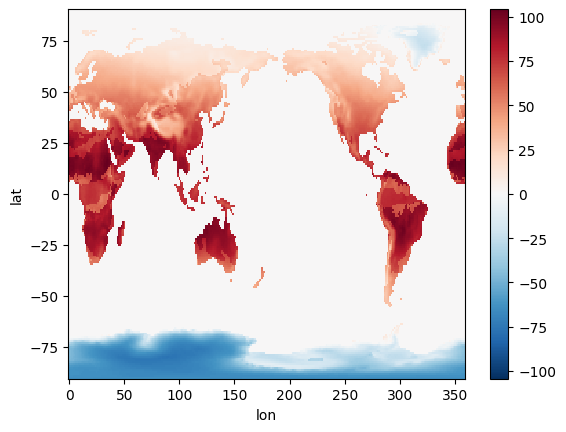

In [59]:
Pthresh = (Pthresh_1+Pthresh_2+Pthresh_3)
Pthresh.plot()

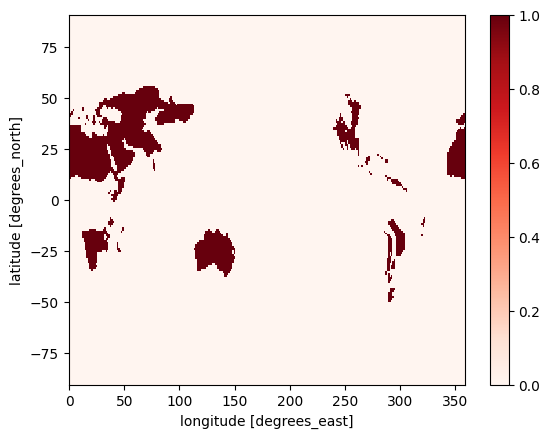

In [60]:
B = xr.where(MAP<(10*Pthresh), True, False)
B.plot(cmap='Reds')

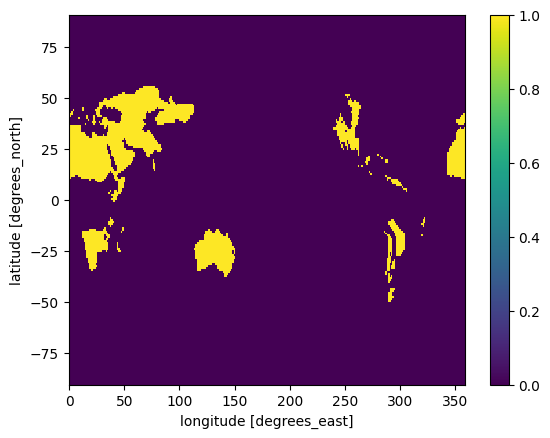

In [61]:
B.plot.pcolormesh()

In [62]:
B.coords

Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

In [63]:
B.min()

<xarray.DataArray ()>
array(False)

In [64]:
B.max()

<xarray.DataArray ()>
array(True)

had to create a custom colormap because the projection was being SO ANNOYING 

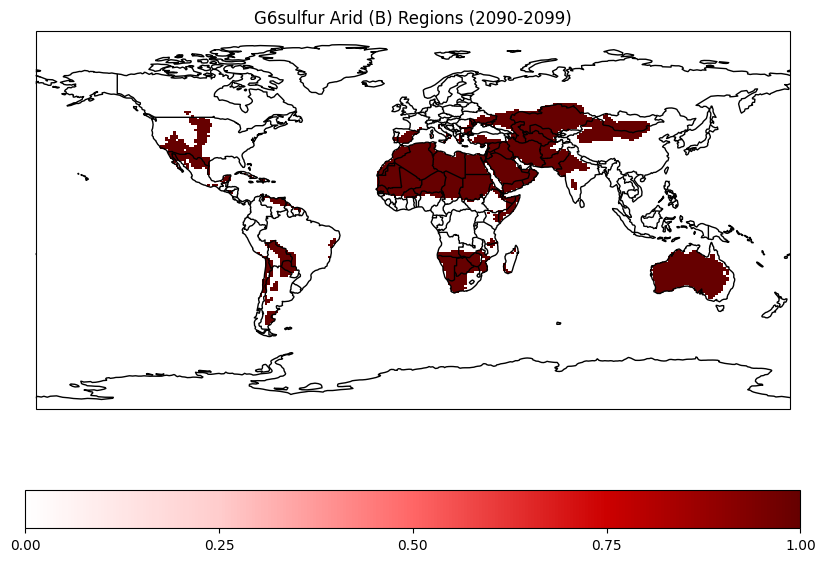

In [65]:
plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

#contour_levels = np.linspace(0, 1, 5)  

colors = ['white', '#ffcccc', '#ff6666', '#cc0000', '#660000']  # specifying exact colors
reds_with_white = LinearSegmentedColormap.from_list('reds_with_white', colors, N=256)

contour_plot = B.plot.pcolormesh(
    ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=reds_with_white, vmin=0, vmax=1, add_colorbar=False)
plt.colorbar(contour_plot, ax=ax, orientation='horizontal', ticks=[0, 0.25, 0.5, 0.75, 1])

#reds_with_white = LinearSegmentedColormap.from_list(
    #'reds_with_white', ['white'] + list(plt.cm.Reds(np.linspace(0.3, 1, 256))))

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

ax.set_title('G6sulfur Arid (B) Regions (2090-2099)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [66]:
BW_wint = xr.where((2*(MAT-273.15))*5>MAP, 1, 0)
BW_sum = xr.where((2*(MAT-273.15)+28)*5>MAP, 1, 0)
BW_othr = xr.where((2*(MAT-273.15)+14)*5>MAP, 1, 0)
BW = (BW_wint + BW_sum + BW_othr)

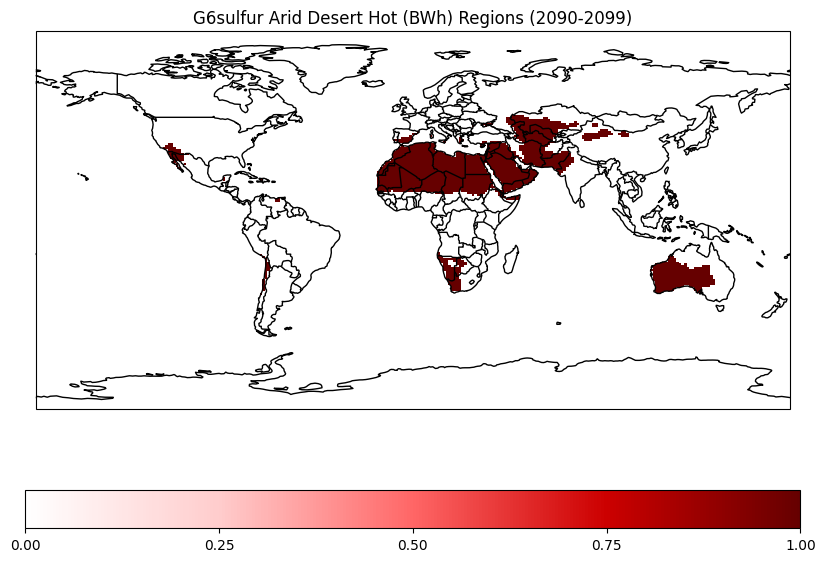

In [67]:
BW_h = xr.where((MAT>=291), BW, 0)

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

colors = ['white', '#ffcccc', '#ff6666', '#cc0000', '#660000']  
reds_with_white = LinearSegmentedColormap.from_list('reds_with_white', colors, N=256)

contour_plot = BW_h.plot.pcolormesh(
    ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=reds_with_white, vmin=0, vmax=1, add_colorbar=False)
plt.colorbar(contour_plot, ax=ax, orientation='horizontal', ticks=[0, 0.25, 0.5, 0.75, 1])

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

ax.set_title('G6sulfur Arid Desert Hot (BWh) Regions (2090-2099)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

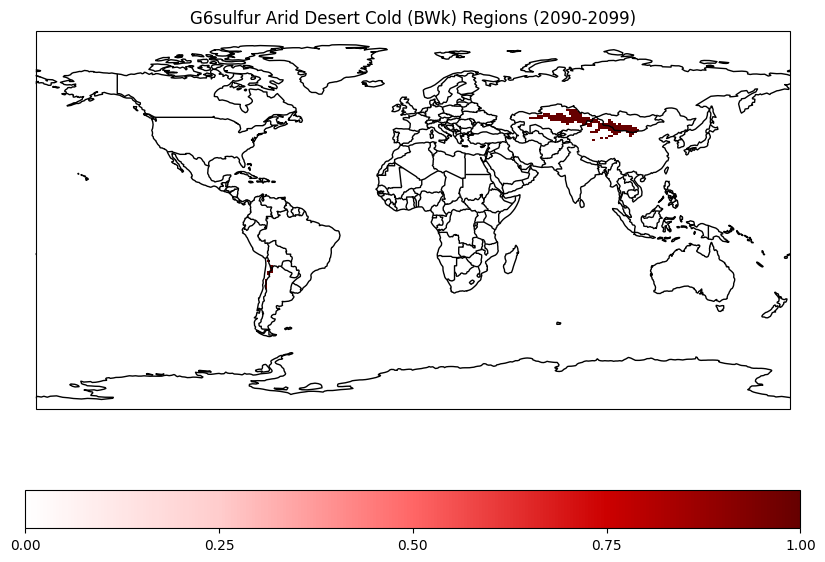

In [68]:
BW_k = xr.where((MAT<291), BW, 0)

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

colors = ['white', '#ffcccc', '#ff6666', '#cc0000', '#660000']  
reds_with_white = LinearSegmentedColormap.from_list('reds_with_white', colors, N=256)

contour_plot = BW_k.plot.pcolormesh(
    ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=reds_with_white, vmin=0, vmax=1, add_colorbar=False)
plt.colorbar(contour_plot, ax=ax, orientation='horizontal', ticks=[0, 0.25, 0.5, 0.75, 1])

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

ax.set_title('G6sulfur Arid Desert Cold (BWk) Regions (2090-2099)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [69]:
BS_wint = xr.where((2*(MAT-273.15))*5<=MAP, 1, 0)
BS_sum = xr.where((2*(MAT-273.15)+28)*5<=MAP, 1, 0)
BS_othr = xr.where((2*(MAT-273.15)+14)*5<=MAP, 1, 0)
#BS = (BS_wint + BS_sum + BS_othr)

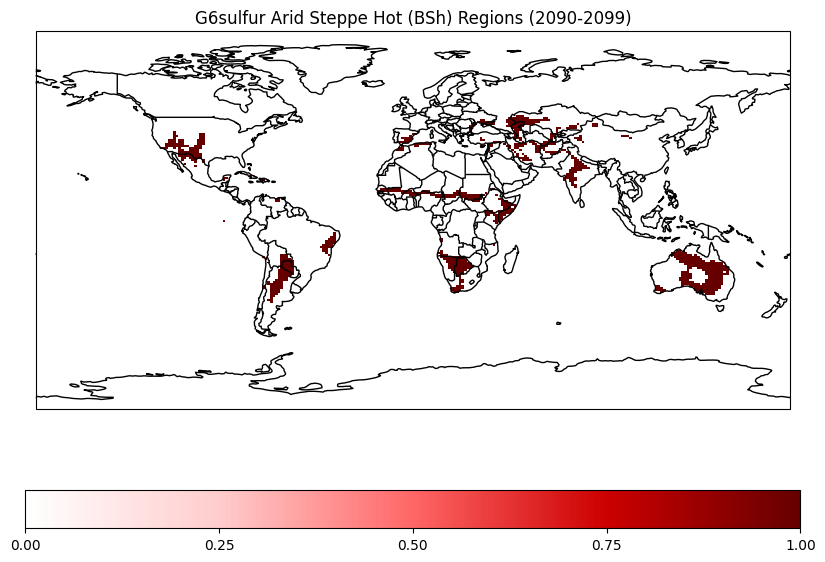

In [70]:
BS_h = xr.where((MAT>=291), BS, 0)

plt.figure(figsize=(10, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

colors = ['white', '#ffcccc', '#ff6666', '#cc0000', '#660000']  
reds_with_white = LinearSegmentedColormap.from_list('reds_with_white', colors, N=256)

contour_plot = BS_h.plot.pcolormesh(
    ax=ax, x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=reds_with_white, vmin=0, vmax=1, add_colorbar=False)
plt.colorbar(contour_plot, ax=ax, orientation='horizontal', ticks=[0, 0.25, 0.5, 0.75, 1])

ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.add_feature(cfeature.COASTLINE, edgecolor='black')

ax.set_title('G6sulfur Arid Steppe Hot (BSh) Regions (2090-2099)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

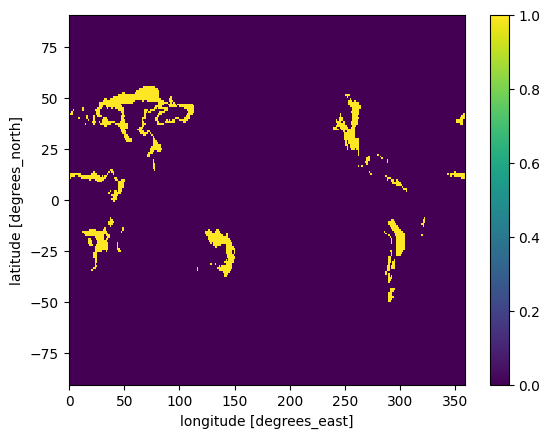

In [71]:
BS = xr.where(np.logical_and(B, (MAP>=5*Pthresh)), True, False)
BS.plot()

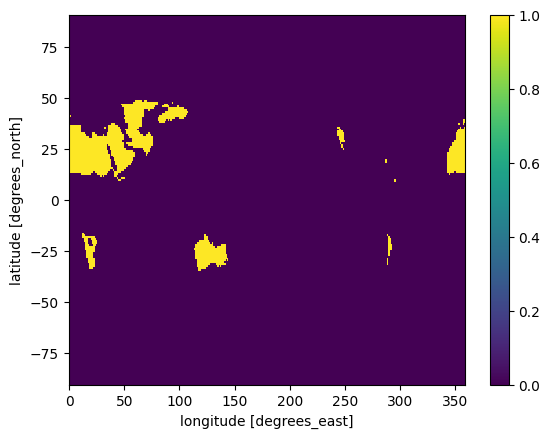

In [72]:
BW = xr.where(np.logical_and(B, (MAP<5*Pthresh)), True, False)
BW.plot()

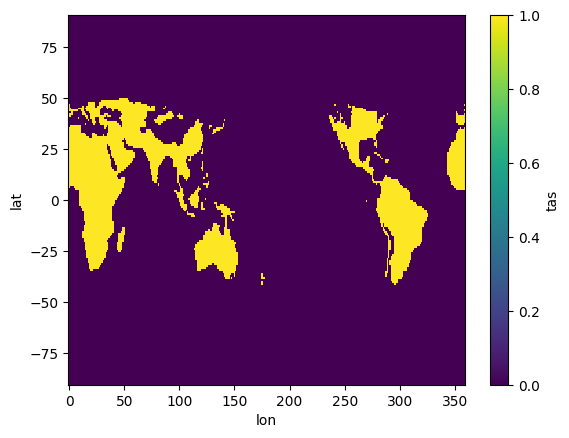

In [73]:
h = xr.where(MAT>=(273.15+18), True, False)
h.plot()

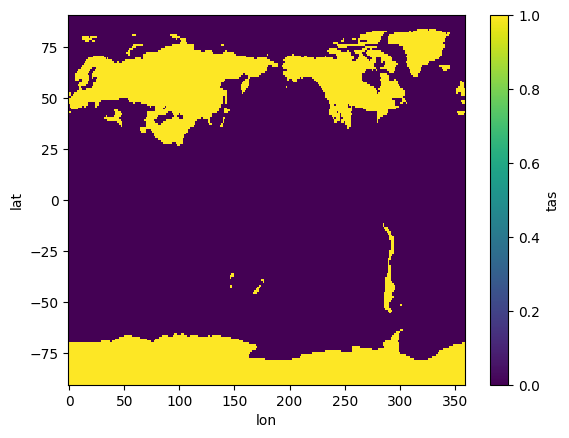

In [74]:
k = xr.where(MAT<(273.15+18), True, False)
k.plot()

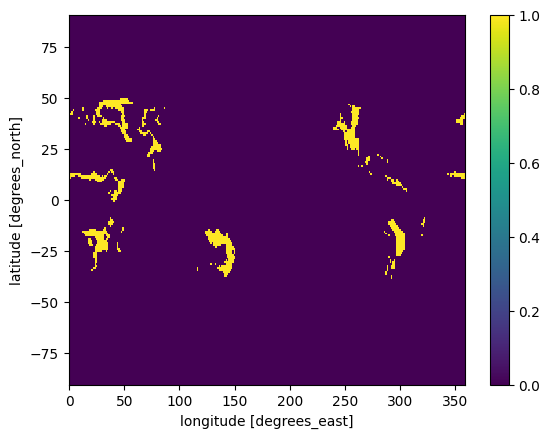

In [75]:
BSh = xr.where(np.logical_and(BS, h), True, False)
BSh.plot()

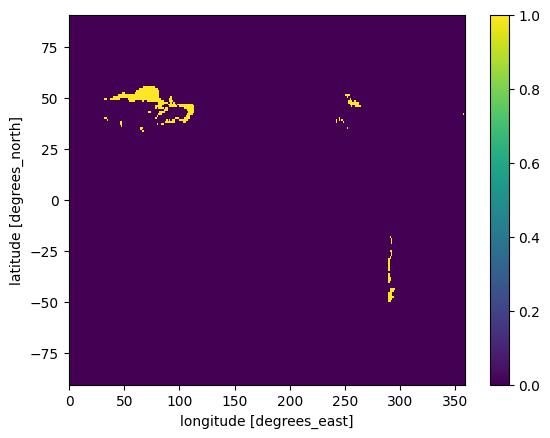

In [76]:
BSk = xr.where(np.logical_and(BS, k), True, False)
BSk.plot()

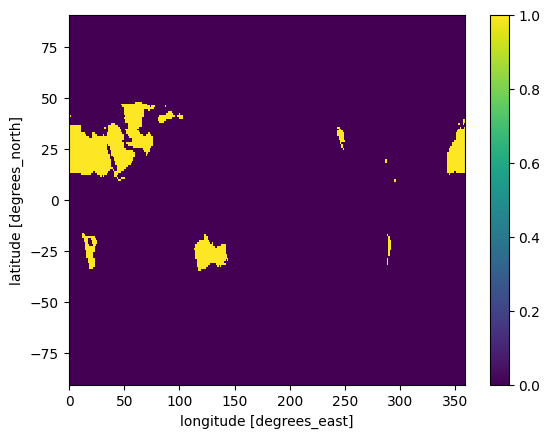

In [77]:
BWh = xr.where(np.logical_and(BW, h), True, False)
BWh.plot()

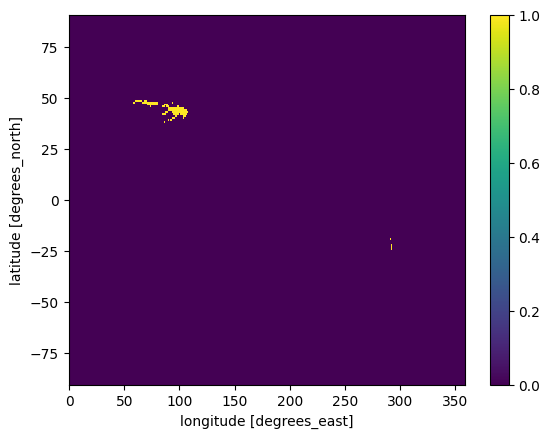

In [78]:
BWk = xr.where(np.logical_and(BW, k), True, False)
BWk.plot()

In [79]:
B

<xarray.DataArray (lat: 192, lon: 288)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

creating new dataset w/ arid criteria only
==

In [80]:
B_set = xr.Dataset()

In [81]:
B_set['lat'] = B.lat
B_set['lon'] = B.lon

In [82]:
B_set

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    *empty*

In [83]:
B_set['B'] = B
B_set['B'].attrs= {'long_name' : 'arid'}
B_set

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    B        (lat, lon) bool False False False False ... False False False False

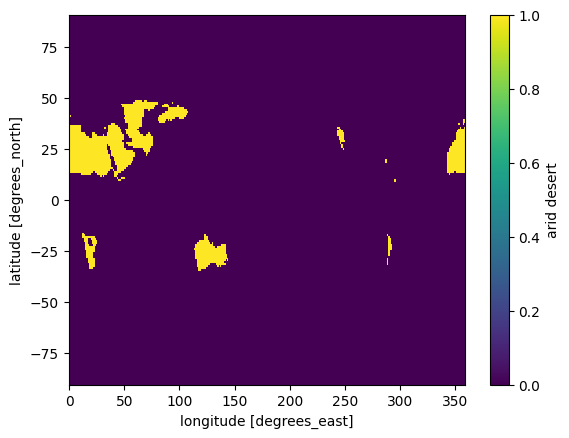

In [84]:
B_set['BW'] = BW
B_set['BW'].attrs = {'long_name' : 'arid desert'}
B_set['BW'].plot()

In [85]:
#line 206 for actually creating netcdf file at end

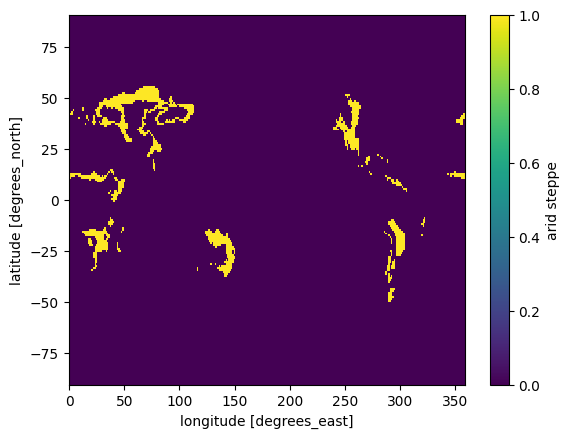

In [86]:
B_set['BS'] = BS
B_set['BS'].attrs = {'long_name' : 'arid steppe'}
B_set['BS'].plot()

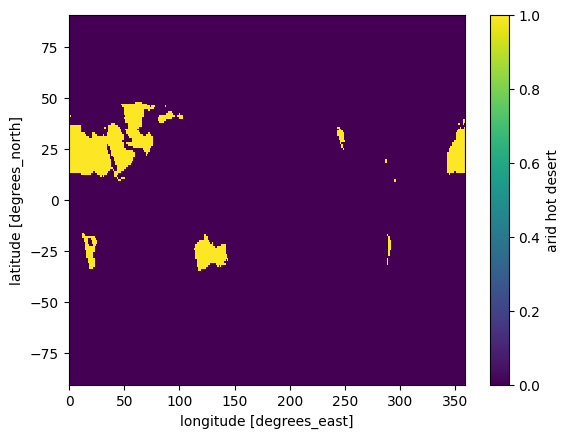

In [87]:
B_set['BWh'] = BWh
B_set['BWh'].attrs = {'long_name' : 'arid hot desert'}
B_set['BWh'].plot()

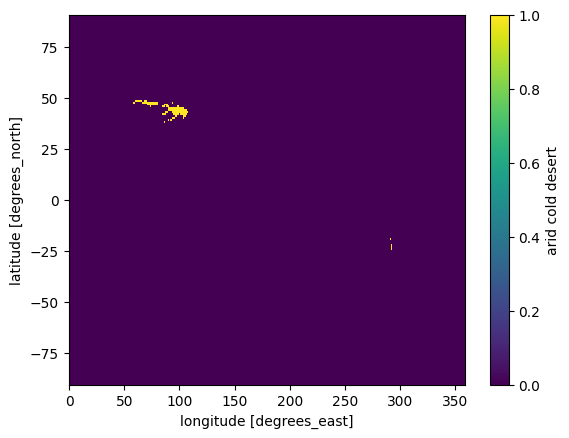

In [88]:
B_set['BWk'] = BWk
B_set['BWk'].attrs = {'long_name' : 'arid cold desert'}
B_set['BWk'].plot()

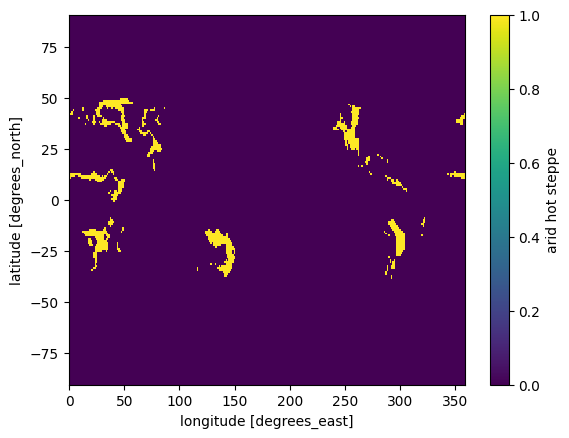

In [89]:
B_set['BSh'] = BSh
B_set['BSh'].attrs = {'long_name' : 'arid hot steppe'}
B_set['BSh'].plot()

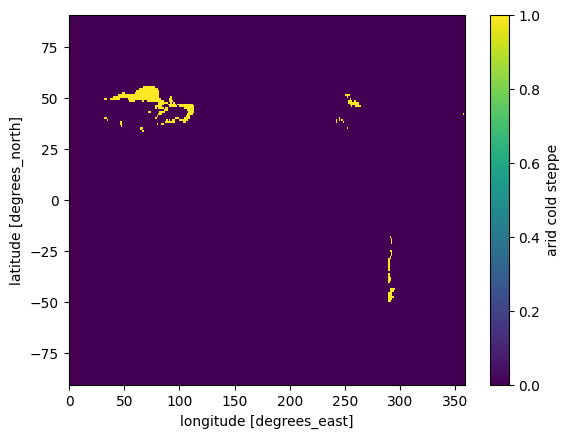

In [90]:
B_set['BSk'] = BSk
B_set['BSk'].attrs = {'long_name' : 'arid cold steppe'}
B_set['BSk'].plot()

In [91]:
B_set

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
Data variables:
    B        (lat, lon) bool False False False False ... False False False False
    BW       (lat, lon) bool False False False False ... False False False False
    BS       (lat, lon) bool False False False False ... False False False False
    BWh      (lat, lon) bool False False False False ... False False False False
    BWk      (lat, lon) bool False False False False ... False False False False
    BSh      (lat, lon) bool False False False False ... False False False False
    BSk      (lat, lon) bool False False False False ... False False False False

In [92]:
B_set.to_netcdf(path='/Users/jaybr/OneDrive/Desktop/UROP/ARID_dataset_2090s_SSP5_8.5.nc', mode='w')